# Project 1: A model for the spread of Rabies

Rabies is a fatal disease affecting a number of animal species, some domestic and some wild. In rare cases it may be contracted by humans, normally through a bite from a rabid dog. In many places it is endemic, but in other countries such as Australia and Britain, it is not currently present, and there are strong efforts being made to keep rabies out. To this end, a number of mathematical models have been developed for the spread of the disease. This project investigates one of these models, and examines the effectiveness of methods by which the spread of the disease could be reduced or prevented. The model is taken from Chapter 20 of “Mathematical Biology”, by J.D. Murray (Springer, 1989, 1st edition; in the 2002 third edition, which appeared in two volumes, the model is in Volume 2, Chapter 13). Copies of the most relevant pages will be given out, and the general features of this kind of modelling will be discussed in lectures.
By far the most significant carriers of rabies during European outbreaks are foxes, so a reasonable approximation for the spread of the disease is to consider the population dynamics of just these animals. (In the US the culprits are raccoons!) Let S be the density per square kilometer of susceptible foxes, ie those that have not yet caught the disease but are liable to do so, and let I be the corresponding density of those that are infectious carriers of the disease. After non-dimensionalisation, the governing equations we will adopt are

$$\large
\frac{\partial S}{\partial t} \ = \ -IS \  +  \ bS(1-S) 
$$
and
$$\frac{\partial I}{\partial t} \ = \ I(S \  -  \ \lambda ) \ + \ \frac{\partial^2 I}{\partial x^2} 
$$

They depend on only one space variable x and so model features such as plane waves spreading parallel to the boundaries across a country which is infinite in one direction and finite in the perpendicular (x) direction. We will suppose the country is isolated geographically (foxes cannot swim, at least not that far), so that boundary conditions ∂I/∂x = 0 will be adopted at both boundaries (corresponding to zero infected fox fluxes there).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from math import log10, floor
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [2]:
# import parameters for rabies
filename = 'rabies.dat'
with open(filename,'r') as fi:
    lines = fi.readlines()
    # Number of meshpoints
    n = int(lines[0].split('%')[0])
    n_str = lines[0].split('%')[1].split('\n')[0]
    # lambda
    lam = float(lines[1].split('%')[0])
    lam_str = lines[1].split('%')[1].split('\n')[0]
    # b
    b = float(lines[2].split('%')[0])
    b_str = lines[2].split('%')[1].split('\n')[0]
    # length of domain in scaled units
    xlen = float(lines[3].split('%')[0])
    xlen_str = lines[3].split('%')[1].split('\n')[0]
    #  xstart - starting point of epidemic
    xstart = float(lines[4].split('%')[0])
    xstart_str = lines[4].split('%')[1].split('\n')[0]
    # xspr - Gaussian spread of infectives around starting point
    xspr = float(lines[5].split('%')[0])
    xspr_str = lines[5].split('%')[1].split('\n')[0]
    # amp - amplitude of Gaussian spread of initial infectives
                            # I0=amp*exp(-((x-xstart)/xspr)**2)
    amp = float(lines[6].split('%')[0])
    amp_str = lines[6].split('%')[1].split('\n')[0]
    # alpha - stability factor of scheme
    alpha = float(lines[7].split('%')[0])
    alpha_str = lines[7].split('%')[1].split('\n')[0]
    # Total integrationt time in scaled units
    T = float(lines[8].split('%')[0])
    T_str = lines[8].split('%')[1].split('\n')[0]
    # Number of plots, including IC
    num_plots = int(lines[9].split('%')[0])
    num_plots_str = lines[6].split('%')[1].split('\n')[0]

print(f'Imported input parameters from {filename}')
print('='*40)
print(f'{n_str}')
print(f'\t n -> {n}\n')        
print(f'{xlen_str}')                  
print(f'\t xlen -> {lam}\n')
print(f'{xstart_str}')
print(f'\t xstart -> {xstart}\n')
print(f'{xspr_str}')
print(f'\txspr -> {xspr}\n')
print(f'{amp_str}')
print(f'\tamp -> {amp}\n')
print(f'{alpha_str}')
print(f'\talpha -> {alpha}\n')
print(f'{T_str}')
print(f'\tT -> {T}\n')
print(f'{num_plots_str}')
print(f'\tnum_plots -> {num_plots}')

Imported input parameters from rabies.dat
 Number of meshpoints n
	 n -> 1001

 Length of domain in scaled units 
	 xlen -> 0.2

 xstart - starting point of epidemic
	 xstart -> 20.0

 xspr - Gaussian spread of infectives around starting point
	xspr -> 5.0

 amp - amplitude of Gaussian spread of initial infectives:  I0=amp*exp(-((x-xstart)/xspr).^2);
	amp -> 0.5

 alpha - stability factor of scheme 
	alpha -> 0.2

 Total integration time in scaled units
	T -> 1300.0

 amp - amplitude of Gaussian spread of initial infectives:  I0=amp*exp(-((x-xstart)/xspr).^2);
	num_plots -> 650


In [3]:
# Second-order Adams-Bashforth

t1 = time.perf_counter()
dx = xlen/n # uniform mesh spacing
dt = alpha*dx*dx
n_t = int(T/dt)
x = np.linspace(0,xlen,n)
I_init = amp*np.exp(-(x-(xstart))**2/(2*(xspr)**2)) 
I_init[0] = (4*I_init[1]-I_init[2])/3
I_init[-1] = (4*I_init[-2]-I_init[-3])/3
S_init = np.ones(len(x))


# Store results for plotting/animation
plot_freq = int(np.floor(n_t/num_plots))
num_plots_saved = int(n_t/plot_freq)
results_S = np.zeros((num_plots_saved+1,n))
results_I = np.zeros((num_plots_saved+1,n))

#initialise using euler
S_0 = S_init
I_0 = I_init
S_1 = S_0 + dt*(-np.multiply(I_0,S_0) + b*(S_0 - np.multiply(S_0,S_0)))

# Generate matrix to estimate second derivative of I
DL = np.zeros(shape = (n,n))
D2 = np.zeros(n)
D2[-1] = 1
D2[0] = -2
D2[1] = 1
for i in np.arange(1,n-1):
    DL[i] = np.roll(D2,i)*(1/((dx)**2))   

I_1 = I_0 + dt*(np.multiply(I_0,S_0) - lam*I_0 + DL.dot(I_0))
I_1[0] = (4*I_1[1]-I_1[2])/3
I_1[-1] = (4*I_1[-2]-I_1[-3])/3

# save_initial results
results_S[0,:] = S_0
results_I[0,:] = I_0

def rhs_S(S,I,IS):
    dS = (-IS + b*(S - np.multiply(S,S)))
    return dS
def rhs_I(S,I,IS):
    dI = (IS - lam*I + DL.dot(I))
    return dI

plotting = True
plot_time = []
plot_time.append(0)
i = 1
IS_0 = np.multiply(I_0,S_0)
ds_0 = rhs_S(S_0,I_0,IS_0)
di_0 = rhs_I(S_0,I_0,IS_0)
for k in tqdm(np.arange(1,n_t)):
    IS_1 = np.multiply(I_1,S_1)
    ds_1 = rhs_S(S_1,I_1,IS_1)
    S_2 = S_1 + 1.5*dt*ds_1 - 0.5*dt*ds_0
    di_1 = rhs_I(S_1,I_1,IS_1)
    I_2 = I_1 + 1.5*dt*di_1 - 0.5*dt*di_0
    I_2[0] = (4*I_2[1]-I_2[2])/3
    I_2[-1] = (4*I_2[-2]-I_2[-3])/3
    #plotting
    if not k%plot_freq and plotting == True:
        plot_time.append(k)
        results_S[i,:] = S_2
        results_I[i,:] = I_2
        i += 1

    # reclassify for next timestep
    IS_0 = IS_1
    ds_0 = ds_1
    di_0 = di_1
    I_0 = I_1
    I_1 = I_2
    S_0 = S_1
    S_1 = S_2  
print('time: {}'.format(time.perf_counter()-t1))

  0%|          | 0/651299 [00:00<?, ?it/s]

100%|██████████| 651299/651299 [00:41<00:00, 15778.12it/s]

time: 41.30048804099897


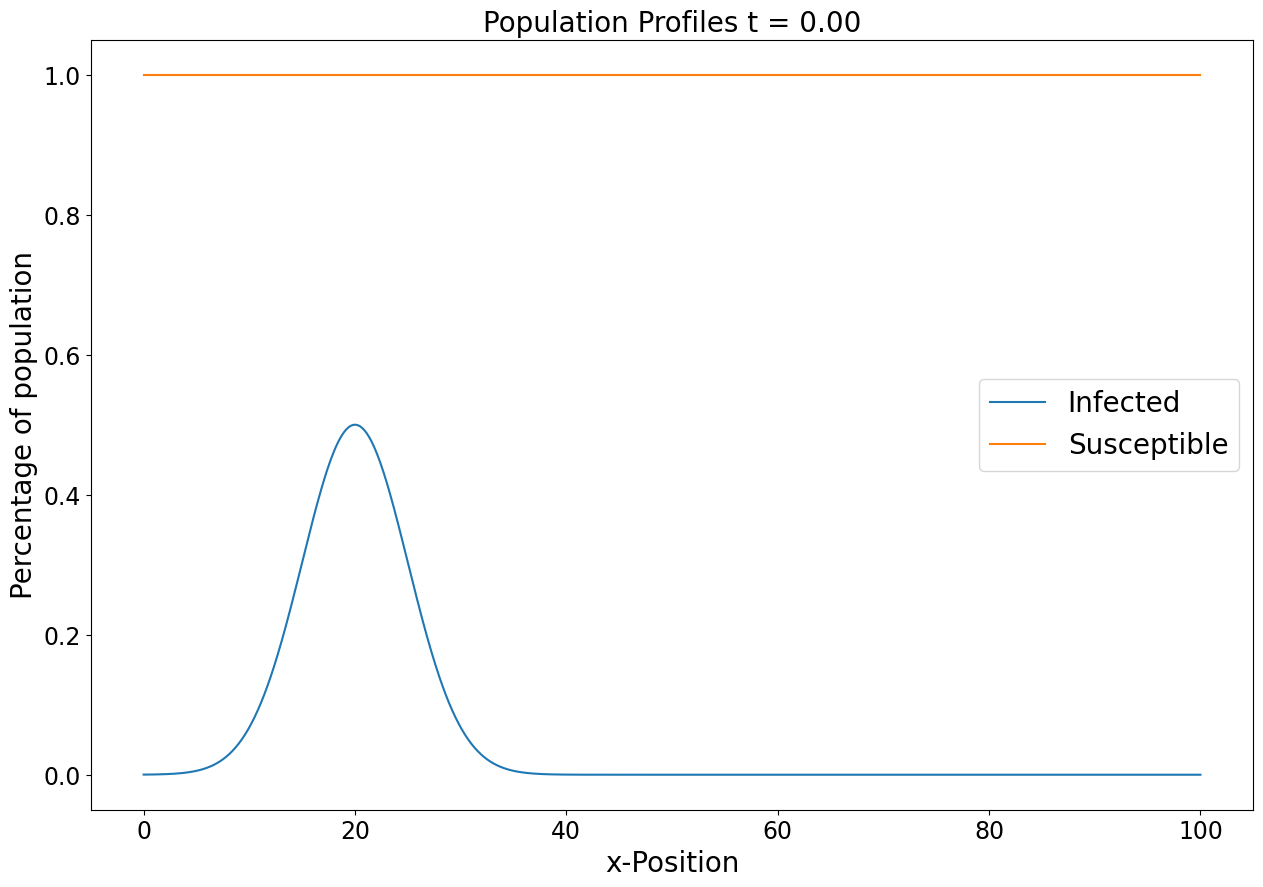

In [4]:
round_to_n = lambda x, n: round(x, -int(floor(log10(x))) + (n - 1)) 

Writer = animation.writers['ffmpeg']
writer = Writer(fps=24, metadata=dict(artist='dshandler'), bitrate=3000)
fig, ax = plt.subplots(1,1,figsize=(15,10))

ax.set_xlabel('x-Position',fontsize=20)
ax.set_ylabel('Percentage',fontsize=20)
ax.set_title('Population Profiles n = 700',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylim([-0.05,1.05])

def update(i):
    ax.clear()    
    ax.set_ylim([-0.05,1.05])
    #ax.set_xlim([20,60])
    ax.plot(x,results_I[i,:],label='Infected')
    ax.plot(x,results_S[i,:],label='Susceptible')
    ax.legend(['Infected','Susceptible'],fontsize=20)
    ax.set_xlabel('x-Position',fontsize=20)
    ax.set_ylabel('Percentage of population',fontsize=20)
    if plot_time[i]>0:
        t = str(round_to_n(plot_time[i]*dt,3))
    else:
        t = '0.00'
    ax.set_title('Population Profiles t = '+t,fontsize=20)
    plt.tick_params(labelsize=17)
ani = animation.FuncAnimation(fig, update, frames=num_plots_saved-1, repeat=True)
ani.save(f'../media/rabies_Q1_n{n}.mp4', writer=writer)

In [ ]:
# parameters
#T0centre = 10
lams = np.arange(0.05,0.96,0.05)
lam_vel = []

n=700
dx = xlen/n # uniform mesh spacing
dt = alpha*dx*dx

n_t = int(T/dt)

x = np.linspace(0,xlen,n)
plot_freq = int(np.floor(n_t/num_plots))
num_plots_saved = int(n_t/plot_freq)

results_S = np.zeros((len(lams)*num_plots_saved,n))
results_I = np.zeros((len(lams)*num_plots_saved,n))

peak_pos = []
wave_vel = []
plot_time = []
plot_time.append(0)
vel_time = []
lam_plot = []
lam_plot.append(0.02)
j = 0
for lam in tqdm(lams):
    I_init = amp*np.exp(-(x-(xstart))**2/(2*(xspr)**2)) 
    I_init[0] = (4*I_init[1]-I_init[2])/3
    I_init[-1] = (4*I_init[-2]-I_init[-3])/3
    S_init = np.ones(len(x))

    #initialise using euler
    S_0 = S_init
    I_0 = I_init
    S_1 = S_0 + dt*(-np.multiply(I_0,S_0) + b*(S_0 - np.multiply(S_0,S_0)))

    # Generate matrix to estimate second derivative of I
    DL = np.zeros(shape = (n,n))
    D2 = np.zeros(n)
    D2[-1] = 1
    D2[0] = -2
    D2[1] = 1
    for i in np.arange(1,n-1):
        DL[i] = np.roll(D2,i)*(1/((dx)**2))   
 
    I_1 = I_0 + dt*(np.multiply(I_0,S_0) - lam*I_0 + DL.dot(I_0))
    I_1[0] = (4*I_1[1]-I_1[2])/3
    I_1[-1] = (4*I_1[-2]-I_1[-3])/3

    range_I_max = int(0.1*n)
    I_max = np.max(I_1[range_I_max:int(0.30*n)])
    x_I_max = np.where(I_1 == I_max)[0][0]
    peak_pos.append(x_I_max*dx)

    def rhs_S(S,I,IS):
        dS = (-IS + b*(S - np.multiply(S,S)))
        return dS
    def rhs_I(S,I,IS):
        dI = (IS - lam*I + DL.dot(I))
        return dI

    plotting = True
    velocity = True
    stop_loop = False
    past30 = False
    past80 = False
    i = 0
    IS_0 = np.multiply(I_0,S_0)
    ds_0 = rhs_S(S_0,I_0,IS_0)
    di_0 = rhs_I(S_0,I_0,IS_0)
    for k in np.arange(1,n_t):
        IS_1 = np.multiply(I_1,S_1)
        ds_1 = rhs_S(S_1,I_1,IS_1)
        S_2 = S_1 + 1.5*dt*ds_1 - 0.5*dt*ds_0
        di_1 = rhs_I(S_1,I_1,IS_1)
        I_2 = I_1 + 1.5*dt*di_1 - 0.5*dt*di_0
        I_2[0] = (4*I_2[1]-I_2[2])/3
        I_2[-1] = (4*I_2[-2]-I_2[-3])/3
        
        #plotting
        if not k%plot_freq and plotting == True:
            plot_time.append(k)
            lam_plot.append(lam)
            i += 1
            
        # measuring initial wave velocity
        if velocity == True:
            range_I_max = int(x_I_max-1)
            I_max = np.max(I_2[range_I_max:])
            x_I_max = np.where(I_2 == I_max)[0][0]
            pos_2 = x_I_max*dx
            peak_pos.append(x_I_max*dx)
            
            if pos_2 >= 30 and past30 == False:
                pos_1 = pos_2
                t1 = k*dt
                past30 = True
            
            pos_2_x = 80
            if pos_2 > pos_2_x and past80 == False:
                wave_vel.append((pos_2-pos_1)/(k*dt-t1))
                past_80 = True
                stop_loop = True

        # reclassify for next timestep
        IS_0 = IS_1
        ds_0 = ds_1
        di_0 = di_1
        I_0 = I_1
        I_1 = I_2
        S_0 = S_1
        S_1 = S_2  
        if stop_loop == True:
            break

    j+=1

100%|██████████| 19/19 [00:13<00:00,  1.39it/s]


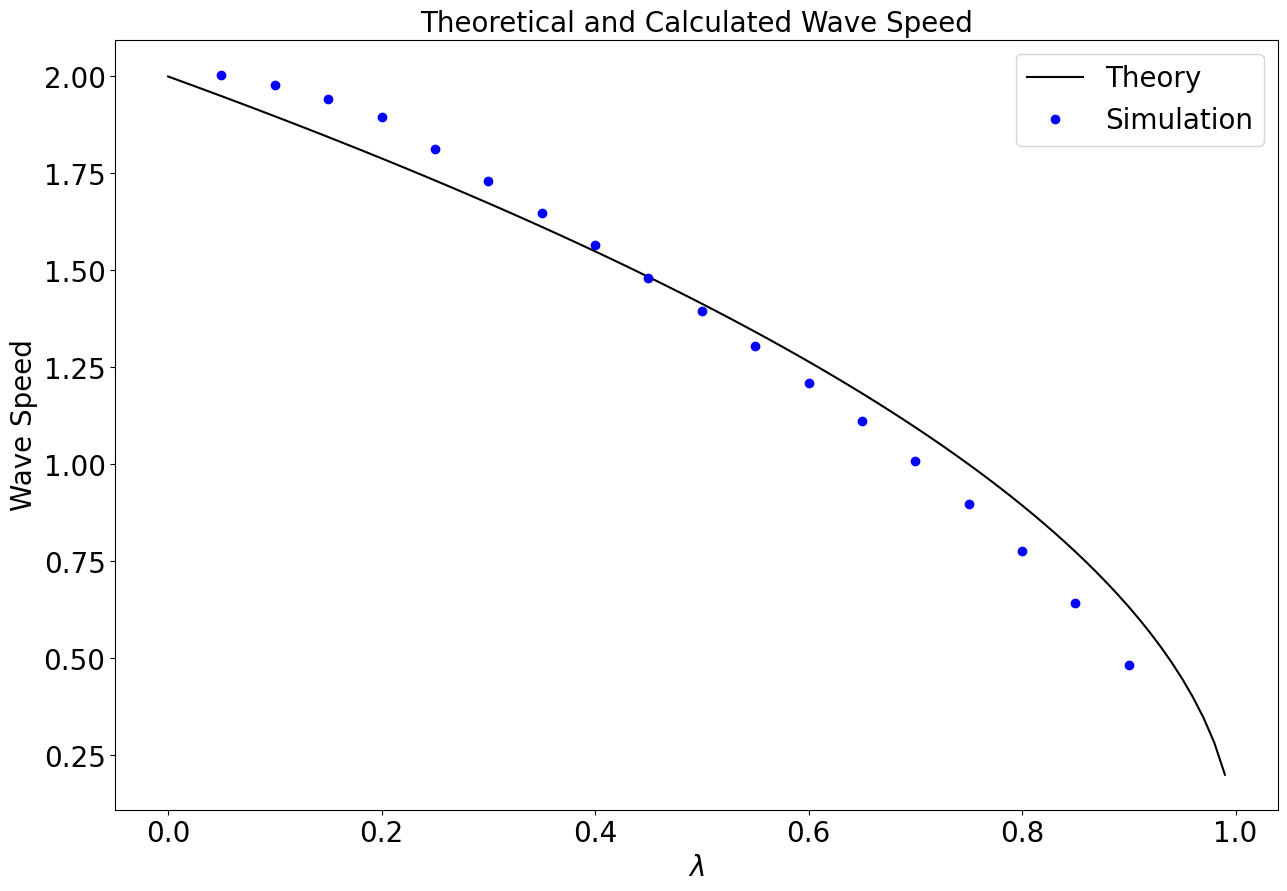

In [ ]:
#plot wave speed relationship
%matplotlib inline
lams_t = np.arange(0,1,0.01) 
lam_vel_t = 2*(1-lams_t)**(1/2)
fig,ax = plt.subplots(1,1,figsize=(15,10))
ax.plot(lams_t,lam_vel_t,'k',label= 'Theory')
ax.plot(lams[:-1],wave_vel[:-1],'ob',label= 'Simulation')
ax.legend(fontsize=20)
ax.set_xlabel(r'$\lambda$',fontsize=20)
ax.set_ylabel('Wave Speed',fontsize=20)
ax.set_title("Theoretical and Calculated Wave Speed",fontsize=20)
ax.tick_params(labelsize=20)
plt.savefig('../media/wave_speed.jpg', dpi=300)